In [1]:
## librerie 
import pandas as pd
import matplotlib.pyplot  as plt
import geopandas as gpd

## Da una stringa legge lultima parte da DX -> SX finchè non trova la virgola
def extract_country(location):
    country= location.split(',')[-1].strip()
    ## gestire la francia
    if (country == 'France'):
        country= location.split(',')[-2].strip()
        
    return country

## Da una stringa trova l'istante temporale di inizio
def find_temporal_start(string):
    if isinstance(string, str):
        return string.split('/')[0].split('T')[0]
    ## potrebbero esserci Nan!!!
    else:
        return ''

In [2]:
## import dataset "space corrected"

df_all_launches= pd.read_csv('datasets/Space_Corrected.csv')
## Le prime due colonne sono inutili, vanno eliminate
df_all_launches.drop(['Unnamed: 0.1', 'Unnamed: 0'], 
                     axis=1, 
                     inplace=True)
## Riformattare data in un formato standard
df_all_launches['Datum'] = pd.to_datetime(df_all_launches['Datum'], 
                                          utc=True, 
                                          errors='coerce')

## Aggiunge una colonna "year" per analisi successiva
year = df_all_launches['Datum'].dt.year
df_all_launches['Year'] = year

# Rimuovi le voci con year minore di 2010
#df_all_launches = df_all_launches[df_all_launches['Year'] >= 2010]


## Estrai i Paesi di lancio dalla colonna Location 
df_all_launches['Country'] = df_all_launches['Location'].apply(extract_country)
df_all_launches.head()

## rinonimare alcuni stati per farlo stampare correttamente nelle mappe della libreria geopandas
df_all_launches['Country'] = df_all_launches['Country'].replace({'USA': 'United States of America'})
df_all_launches['Country'] = df_all_launches['Country'].replace({'French Guiana': 'Guyana'})



In [3]:
## import dataset "data_nasa_formatted" -> nasa_datasets

## Il numero dei dataset fa da sostituto ai dati prodotto dalla Nasa 

df_data_nasa_formattato = pd.read_json('datasets/data_nasa_formattato.json')

## estrai dati con pd.json_normalize()
df_nasa_datasets = pd.json_normalize(df_data_nasa_formattato['dataset'])

## estrapola data inizio esperimenti: NB: occhio a Nan
df_nasa_datasets['temporal_start'] = df_nasa_datasets['temporal'].apply(find_temporal_start)

df_nasa_datasets = df_nasa_datasets[['title', 'issued', 'modified', 'temporal_start', 'theme']]

In [4]:
## import dataset "nasa_budget_corrected" -> nasa_annual_budget
df_nasa_annual_budget= pd.read_csv('datasets/nasa_budget_corrected.csv')

# Analisi preliminare

C:\Users\Thomas\AppData\Local\Temp\ipykernel_8804\669129802.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(company_names,


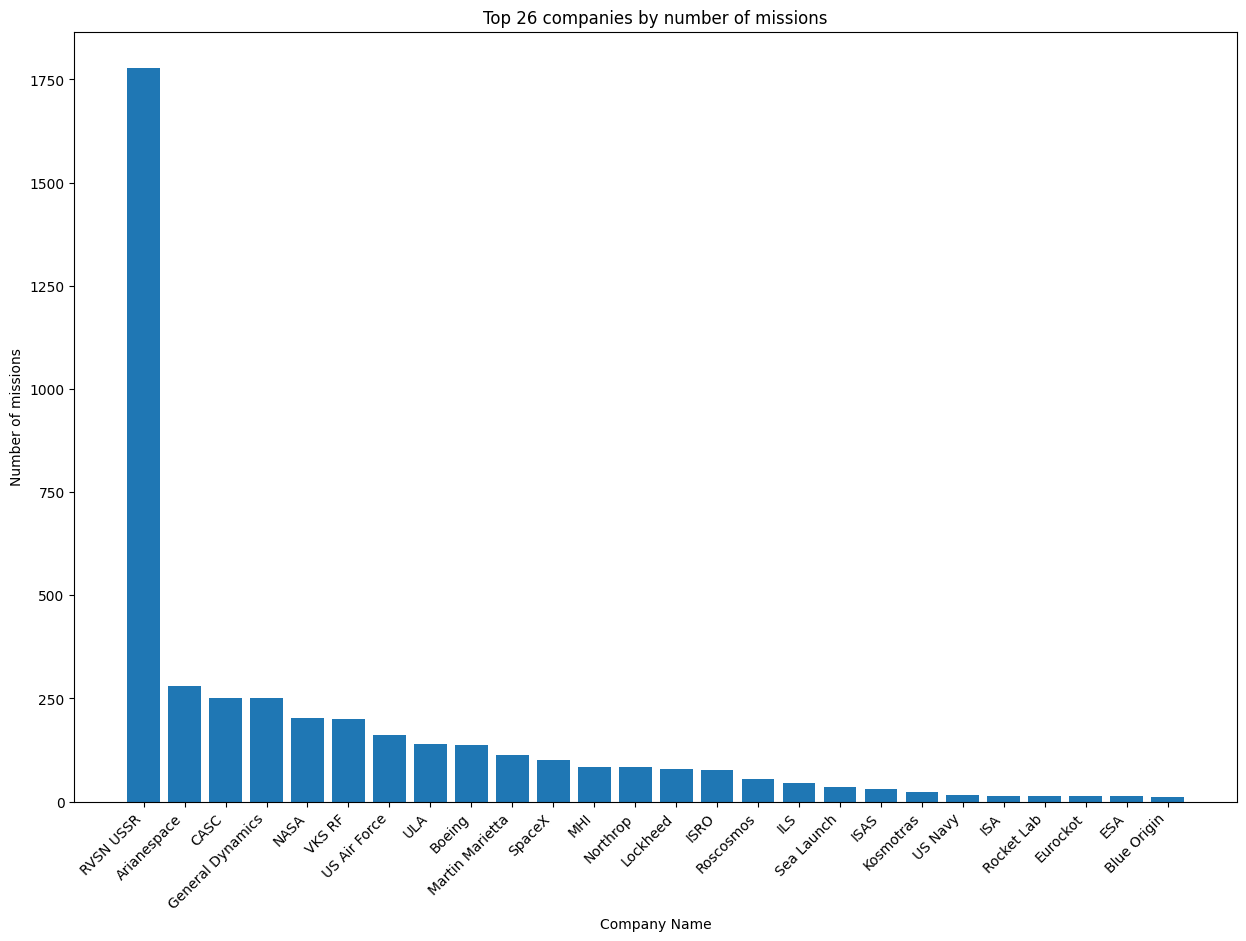

In [5]:
## chi lancia
## per motivi di leggibilità sono state selezionate le prime 26 aziende
## (fino alla blue origin)

company_launches = df_all_launches['Company Name'].value_counts().head(26)

company_names = company_launches.index
nr_company_launches = company_launches.values

## plot
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

ax.bar(company_names, nr_company_launches)

ax.set_xticklabels(company_names, 
                   rotation=45, 
                   ha='right')

ax.set_title('Top 26 companies by number of missions')
ax.set_xlabel('Company Name')
ax.set_ylabel('Number of missions')

plt.show()


C:\Users\Thomas\AppData\Local\Temp\ipykernel_8804\2082096934.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


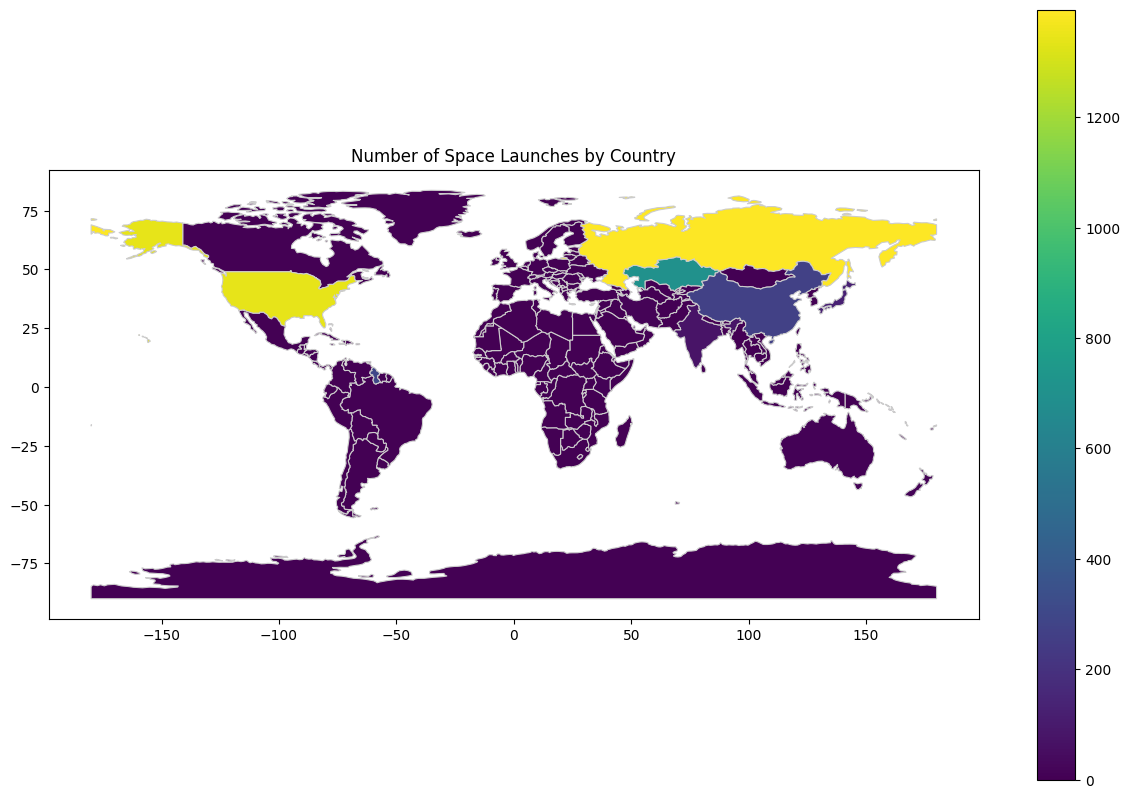

In [6]:
## da dove si lancia

launches_by_country = df_all_launches['Country'].value_counts()

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world_launches= world.merge(launches_by_country, 
                   how='left', 
                   left_on='name', 
                   right_index=True
                   )

world_launches.rename(columns={'count': 'country_launches'}, inplace=True)

world_launches['country_launches'].fillna(0, inplace= True)

## plot

fig, ax = plt.subplots(figsize=(15, 10))

world_launches.plot(column='country_launches',
                    linewidth=0.8, 
                    ax=ax, 
                    edgecolor='0.8', 
                    legend=True)

ax.set_title('Number of Space Launches by Country')

plt.show()

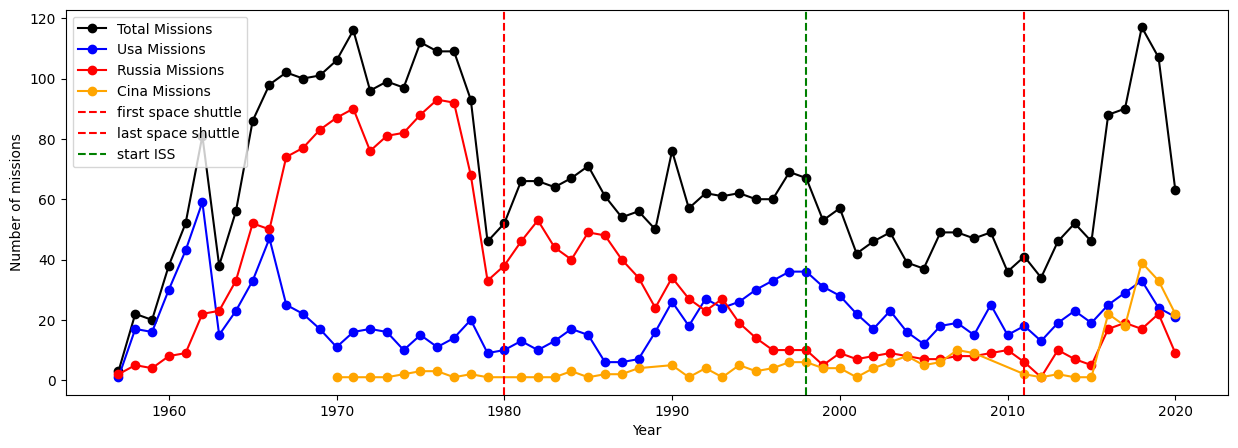

In [13]:
## cronologia lanci

missions_by_year = df_all_launches.groupby('Year').size()

years = missions_by_year.index
launches_by_year = missions_by_year.values

#United States of America #Russia #Kazakhstan #China #India

## USA
usa_launches = df_all_launches[df_all_launches['Country'] == 'United States of America'] 
usa_launches = usa_launches.groupby('Year').size()

usa_years = usa_launches.index
usa_launches_by_year = usa_launches.values

## Russia
russia_launches = df_all_launches[(df_all_launches['Country'] == 'Russia') | (df_all_launches['Country'] =='Kazakhstan')] 
russia_launches = russia_launches.groupby('Year').size()

russia_years = russia_launches.index
russia_launches_by_year = russia_launches.values

## Cina

cina_launches = df_all_launches[(df_all_launches['Country'] == 'China')] 
cina_launches = cina_launches.groupby('Year').size()

cina_years = cina_launches.index
cina_launches_by_year = cina_launches.values

## plot
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(years, launches_by_year, 
        marker='o',
        color='black', 
        label='Total Missions',
        )

ax.plot(usa_years, usa_launches_by_year, 
        marker='o', 
        color='blue', 
        label='Usa Missions',
        )

ax.plot(russia_years, russia_launches_by_year, 
        marker='o', 
        color='red', 
        label='Russia Missions',
        )

ax.plot(cina_years, cina_launches_by_year, 
        marker='o', 
        color='orange', 
        label='Cina Missions',
        )

ax.set_xlabel('Year')
ax.set_ylabel('Number of missions')

## linee verticali per le date interessanti
ax.axvline(x=1980, color='red', linestyle='--', label='first space shuttle')
ax.axvline(x=2011, color='red', linestyle='--', label='last space shuttle')
ax.axvline(x=1998, color='green', linestyle='--', label='start ISS')

ax.legend()

plt.show()
